Importing Libraries

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import re
import pandas as pd
import numpy as np
import pandas as pd
import re
!pip install langdetect
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import nltk
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=701d9ad6757e43c0d6468deaed015122bb7ae521ee7531c26624c33237ac0e61
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Dataset Loading

In [4]:
df = pd.read_excel("FinalDataset.xlsx", dtype={'Body': str})

In [5]:
df.head()

,Date,Body,Sentiment
0,2022-03-03,The firm stated in a release that it was estab...,-1.0
1,2022-03-07,Russian banks have indicated that they may loo...,-1.0
2,2022-04-12,Bitfinex and Tether set up a crypto relief fun...,-1.0
3,2022-04-25,"For us, we think the cryptocurrency markets re...",-1.0
4,2022-05-05,Binance is backing Elon Musk's takeover of Twi...,-1.0


In [6]:
df.shape

(4821, 3)

In [7]:
df.dtypes

Date         datetime64[ns]
Body                 object
Sentiment           float64
dtype: object

In [8]:
df['Body'] = df['Body'].apply(lambda x: str(x))

In [9]:
mixed_types = df['Body'].apply(type).unique()
print(mixed_types)

[<class 'str'>]


In [10]:
df['Body'] = df['Body'].str.lower()

Data Preprocessing

In [11]:
# Load English language model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Mapping dictionary for contractions to full forms
contraction_mapping = {
    "should've": "should have",
    "shouldn't": "should not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "aren't": "are not",
    "isn't": "is not",
    "weren't": "were not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "couldn't": "could not",
    "mightn't": "might not",
    "mustn't": "must not",
}

# Function to convert all words to lowercase
def lowercase(text):
    return text.lower()

# Function to expand contractions
def expand_contractions(text):
    for contraction, expansion in contraction_mapping.items():
        text = text.replace(contraction, expansion)
    return text

# Function to remove non-English tweets
def remove_non_english_tweets(text):
    try:
        if detect(text) == 'en':
            return text
        else:
            return ''
    except:
        return ''

# Function to remove duplicate tweets
def remove_duplicate_tweets(df):
    return df.drop_duplicates(subset=["Body"])

# Function to remove URLs from tweets
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Function to remove stop words
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    # Define additional words you want to keep
    additional_stopwords = {'against', 'no', 'down', 'not', 'below', 'out', 'above', 'won'}
    # Remove the additional stopwords from the set
    stop_words -= additional_stopwords
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Function to replace user mentions with 'USER'
def replace_user_mentions(text):
    return re.sub(r'@\w+', 'USER', text)

# Function to remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Function to remove tweets with fewer than 4 words
def remove_short_tweets(text):
    if len(text.split()) >= 4:
        return text
    else:
        return ''

# Function for tokenization and lemmatization
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [12]:
df["Body"] = df["Body"].apply(lowercase)
df["Body"] = df["Body"].apply(expand_contractions)
df.loc[:, "Body"] = df["Body"].apply(remove_non_english_tweets)
df.loc[:, "Body"] = df["Body"].apply(remove_urls)
df.loc[:, "Body"] = df["Body"].apply(remove_stopwords)
df.loc[:, "Body"] = df["Body"].apply(replace_user_mentions)
df.loc[:, "Body"] = df["Body"].apply(remove_punctuation)
df.loc[:, "Body"] = df["Body"].apply(remove_short_tweets)
df.loc[:, "Body"] = df["Body"].apply(tokenize_and_lemmatize)

In [89]:
# Now, randomly remove 1000 rows with sentiment 0
rows_to_remove = df[df['Sentiment'] == 0].sample(1000).index
df_filtered = df.drop(rows_to_remove)

In [20]:
#shuffling the dataframe
new_df = df.sample(frac=1, random_state=42)

In [86]:
new_df

,Date,Body,Sentiment,Vector
4343,2022-07-08,us department treasury present president joe b...,0.30,"[-0.10913493, 0.05937805, 0.043637086, 0.13158..."
1221,2022-02-08,cash app mention lightning network feature not...,0.00,"[0.0017547607, -0.037887573, -0.06442261, 0.04..."
2083,2022-06-30,despite rapid decline crypto market buying a...,0.00,"[-0.009234619, -0.0095855715, -0.0640625, 0.05..."
1044,2021-12-14,russian central bank move bar financial firm c...,0.00,"[-0.03922896, 0.040527344, -0.0010417592, 0.13..."
2567,2022-10-13,cryptocurrency market go enhanced volatility w...,0.00,"[-0.035260882, 0.04010882, -0.13795689, 0.1702..."
...,...,...,...,...
4426,2022-02-28,bitcoin btc break above usd 40000 mark tod...,0.35,"[-0.10317993, 0.006887436, -0.055908203, 0.125..."
466,2022-05-23,slight improvement equity market resilience ke...,-0.12,"[-0.013710022, 0.00071207684, -0.051940918, 0...."
3092,2022-04-01,21shares submit spot bitcoin etf application a...,0.07,"[-0.06499967, 0.06795155, -0.015380859, -0.052..."
3772,2022-02-24,cryptoquant ceo believe major hodler like mi...,0.17,"[-0.012426758, -0.0005027771, 0.0045391084, 0...."


LSTM

In [90]:
content=df_filtered['Body']
polarity=df_filtered['Sentiment']

In [92]:
# Split datasets into training, testing, and validation datasets
X_train, X_val_test, y_train, y_val_test = train_test_split(content,
                                                            polarity,
                                                            random_state=42,
                                                            train_size=.8
                                                            )

X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                random_state=42,
                                                train_size=.5
                                                )

In [93]:
# Confirm dataset sizes
print('Train: ', len(X_train),len(y_train))
print('Test: ', len(X_val),len(y_val))
print('Validation: ', len(X_test),len(y_test))

Train:  3056 3056
Test:  382 382
Validation:  383 383


In [94]:
# Get length of longest tweet
max_len = max([len(tweet.split()) for tweet in df_filtered['Body']])
print(max_len)

40


In [95]:
# Train tokeniser on dataset
from keras.preprocessing.text import Tokenizer
tokeniser=Tokenizer()
tokeniser.fit_on_texts(df_filtered['Body'])

In [96]:
# Check how many unique word are in dataset
vocab = tokeniser.word_index

print("{} unique words in the dataset".format(len(vocab)))

7474 unique words in the dataset


In [97]:
y_train = (y_train.to_list())
y_val = (y_val.to_list())
y_test = (y_test.to_list())

In [98]:
import numpy as np

# Convert y_train to a NumPy array
y_train = np.array(y_train)

# Reshape y_train
y_train = y_train.reshape(-1, 1)

# Reshape y_val and y_test
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [60]:
# Confirm dataset shape

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3856, 1)
y_val shape: (482, 1)
y_test shape: (483, 1)


In [99]:
# Pad training, valdiation and testing datasets
from keras.utils import pad_sequences
X_train = pad_sequences(tokeniser.texts_to_sequences(X_train), maxlen = max_len)

X_val = pad_sequences(tokeniser.texts_to_sequences(X_val), maxlen = max_len)

X_test = pad_sequences(tokeniser.texts_to_sequences(X_test), maxlen = max_len)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (3056, 40)
X_val shape:  (382, 40)
X_test shape:  (383, 40)


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [100]:
# Load gloVe pretrained embedding layer

from numpy import zeros, asarray

path = '/content/drive/My Drive/glove.twitter.27B.100d.txt'
glove_dimentions = 100

f = open(path,'r',encoding="utf-8")
glove = f.readlines()
f.close()

In [101]:
embedding = dict()
for line in glove:
    parts = line.split()
    embedding[parts[0]] = asarray(parts[1:], dtype='float32')

vocab_size = len(vocab) + 1
embedding_matrix = zeros((vocab_size, glove_dimentions))

for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [102]:
# Define LTSM model
from keras import layers
def create_lstm():
  model=Sequential()

  model.add(layers.Embedding(vocab_size,
                            glove_dimentions,
                            weights = [embedding_matrix],
                            input_length = max_len,
                            trainable = False))

  model.add(layers.Bidirectional(layers.LSTM(128, dropout = 0.2)))

  model.add(layers.Dense(1, activation = "tanh"))

  print(model.summary())

  return model

In [103]:
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.models import Sequential
# Define LTSM hyperparameters
ltsm_model = create_lstm()  # Assuming you've defined create_lstm() to create the LSTM model
BATCH_SIZE = 128
EPOCHS = 15
LR = 0.001
optimizer = optimizers.Adam(lr=LR)

# Compile and train LTSM model
ltsm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.0001)

# Train the model
history = ltsm_model.fit(X_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_val, y_val),
                         epochs=EPOCHS,
                         verbose=1,
                         callbacks=[reduce_lr]
                         )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           747500    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 982253 (3.75 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 747500 (2.85 MB)
_________________________________________________________________


None
Epoch 1/15
24/24 [==============================] - 18s 507ms/step - loss: 0.0545 - mae: 0.1710 - val_loss: 0.0604 - val_mae: 0.1726 - lr: 0.0010
Epoch 2/15
24/24 [==============================] - 8s 315ms/step - loss: 0.0485 - mae: 0.1599 - val_loss: 0.0612 - val_mae: 0.1740 - lr: 0.0010
Epoch 3/15
24/24 [==============================] - 9s 392ms/step - loss: 0.0464 - mae: 0.1554 - val_loss: 0.0608 - val_mae: 0.1803 - lr: 0.0010
Epoch 4/15
24/24 [==============================] - 7s 309ms/step - loss: 0.0454 - mae: 0.1544 - val_loss: 0.0623 - val_mae: 0.1856 - lr: 0.0010
Epoch 5/15
24/24 [==============================] - 10s 411ms/step - loss: 0.0431 - mae: 0.1514 - val_loss: 0.0610 - val_mae: 0.1786 - lr: 1.0000e-04
Epoch 6/15
24/24 [==============================] - 8s 355ms/step - loss: 0.0428 - mae: 0.1500 - val_loss: 0.0612 - val_mae: 0.1820 - lr: 1.0000e-04
Epoch 7/15
24/24 [==============================] - 8s 334ms/step - loss: 0.0427 - mae: 0.1501 - val_loss: 0.0610 -

In [104]:
# Evaluate the model on the test dataset
test_loss, test_mae = ltsm_model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

12/12 [==============================] - 1s 54ms/step - loss: 0.0462 - mae: 0.1604
Test Loss: 0.046220384538173676
Test MAE: 0.1604001671075821


In [105]:
y_pred = ltsm_model.predict(X_test)

12/12 [==============================] - 2s 52ms/step


In [106]:
for i in range(0, len(y_pred)):
  print(y_pred[i], y_test[i], sep=',')

[0.03962394],[-0.1]
[0.06885925],[-0.3]
[0.01603856],[0.2]
[0.11224209],[-0.04]
[0.05626443],[0.5]
[0.03455],[-0.16]
[0.12278743],[0.02]
[0.02118083],[0.]
[-0.01486312],[0.12]
[0.03548441],[-0.16]
[0.08392951],[0.5]
[0.06145834],[-0.1]
[0.13486342],[0.12]
[0.05387289],[-0.5]
[0.08252803],[0.]
[0.1634732],[0.]
[0.05729139],[-0.12]
[0.08092886],[0.18]
[0.04630994],[-0.07]
[0.1134074],[0.11]
[-0.00186416],[0.5]
[0.07129033],[0.14]
[0.04675106],[0.]
[0.05113806],[0.5]
[0.06970133],[-0.05]
[0.09178326],[0.12]
[0.03610082],[0.]
[0.04343166],[0.25]
[0.1238122],[0.]
[-0.00281525],[0.16]
[0.0743872],[0.5]
[0.07071413],[0.2]
[0.05891702],[0.03]
[0.03886355],[0.]
[0.08799911],[0.5]
[-0.02552782],[0.25]
[-0.005136],[0.]
[0.13224453],[-0.35]
[0.09960551],[-0.16]
[0.05637221],[0.25]
[0.0837209],[0.07]
[0.04687933],[0.25]
[-0.01449213],[-0.16]
[0.10862311],[0.38]
[0.08609894],[0.5]
[0.07129033],[0.06]
[0.12248357],[0.17]
[0.00349617],[0.12]
[0.00487953],[0.1]
[0.06176195],[0.]
[-0.01339698],[-0.05]
[

In [19]:
count = 0
for i in range(0,len(df['Body'])):
  if(df['Sentiment'].iloc[i] == 0):
    count += 1

print(count)

1703


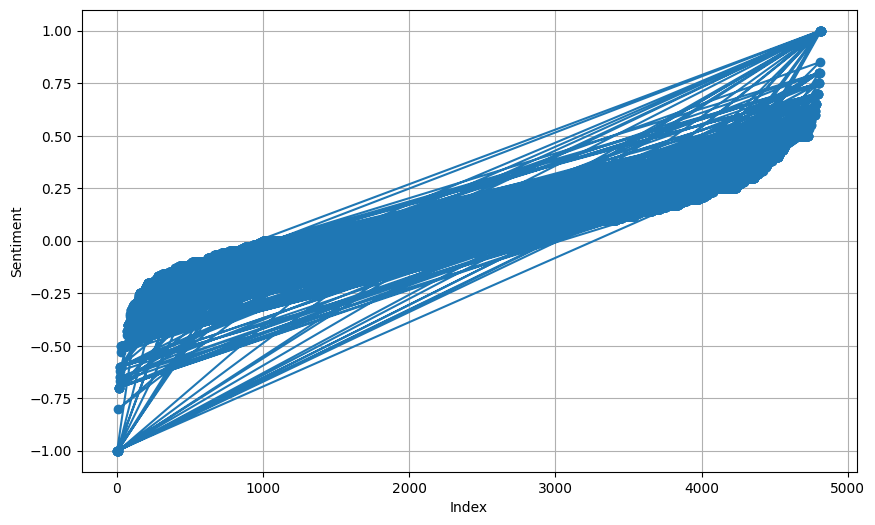

In [21]:
# Plotting sentiment values
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['Sentiment'], marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()

Converting text to vectors(using word embeddings)


In [23]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [24]:
# Load the pre-trained word embeddings model
word_vectors = KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

In [25]:
# Function to convert text into word embeddings
def text_to_vector(text):
    words = simple_preprocess(text)  # Tokenize the text
    vector = [word_vectors[word] for word in words if word in word_vectors]  # Convert each word to its embedding vector
    if vector:
        return sum(vector) / len(vector)  # Return the average vector of all word vectors
    else:
        return [0] * 300  # Return a zero vector if no word in the text is found in the word embeddings model

In [30]:
# Apply the function to the 'Body' column to get word embeddings for each text
new_df['Vector'] = new_df['Body'].apply(text_to_vector)

Model Training

In [ ]:
# Split the data into training and testing sets
X = np.array(df['Vector'].tolist())
y = np.array(df['Sentiment'].tolist())

# Normalize the target variable to the range [-1, 1]
y_normalized = 2 * ((y - min(y)) / (max(y) - min(y))) - 1

X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

In [ ]:
# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)
linear_reg_pred = linear_reg.predict(X_test_scaled)
linear_reg_mse = mean_squared_error(y_test, linear_reg_pred)
print("Linear Regression MSE:", linear_reg_mse)

Linear Regression MSE: 0.04499788916188058


In [ ]:
# Support Vector Regression (SVR)
svr = SVR()
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)
print("SVR MSE:", svr_mse)


SVR MSE: 0.04766568730738175


In [ ]:
# Random Forest Regression
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
print("Random Forest Regression MSE:", random_forest_mse)

Random Forest Regression MSE: 0.04426726641770651


In [ ]:
# Gradient Boosting Regression
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)
gradient_boosting_pred = gradient_boosting.predict(X_test)
gradient_boosting_mse = mean_squared_error(y_test, gradient_boosting_pred)
print("Gradient Boosting Regression MSE:", gradient_boosting_mse)

Gradient Boosting Regression MSE: 0.044056462451801635


Hyperparameter Tuning of the Models

In [ ]:
# Define hyperparameters grid for each model
param_grid_linear_reg = {
    'fit_intercept': [True, False]
}

param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid_random_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gradient_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search cross-validation for each model
grid_search_linear_reg = GridSearchCV(LinearRegression(), param_grid_linear_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_random_forest = GridSearchCV(RandomForestRegressor(), param_grid_random_forest, cv=5, scoring='neg_mean_squared_error')
grid_search_gradient_boosting = GridSearchCV(GradientBoostingRegressor(), param_grid_gradient_boosting, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search objects to the data
grid_search_linear_reg.fit(X_train, y_train)
grid_search_svr.fit(X_train, y_train)
grid_search_random_forest.fit(X_train, y_train)
grid_search_gradient_boosting.fit(X_train, y_train)

# Get the best hyperparameters and corresponding MSE for each model
best_params_linear_reg = grid_search_linear_reg.best_params_
best_score_linear_reg = -grid_search_linear_reg.best_score_

best_params_svr = grid_search_svr.best_params_
best_score_svr = -grid_search_svr.best_score_

best_params_random_forest = grid_search_random_forest.best_params_
best_score_random_forest = -grid_search_random_forest.best_score_

best_params_gradient_boosting = grid_search_gradient_boosting.best_params_
best_score_gradient_boosting = -grid_search_gradient_boosting.best_score_

print("Best Parameters for Linear Regression:", best_params_linear_reg)
print("Best MSE for Linear Regression:", best_score_linear_reg)

print("Best Parameters for SVR:", best_params_svr)
print("Best MSE for SVR:", best_score_svr)

print("Best Parameters for Random Forest Regression:", best_params_random_forest)
print("Best MSE for Random Forest Regression:", best_score_random_forest)

print("Best Parameters for Gradient Boosting Regression:", best_params_gradient_boosting)
print("Best MSE for Gradient Boosting Regression:", best_score_gradient_boosting)


KeyboardInterrupt: 